In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
from pprint import pprint as pprint
import collections
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import Table, DropTable
import pandas as pd

In [4]:
Session = sessionmaker()
engine = create_engine('sqlite:///twitter.db')

In [5]:
# All distinct users

distinctUsers = pd.read_sql_query('SELECT user_id FROM user', engine)
print(len(distinctUsers))

42232


In [6]:
# Users whose posts had been retweeted

authorsOfRetweetedPosts = pd.read_sql_query(
                          'SELECT user1.user_name AS user \
                           FROM user AS user1 \
                           WHERE user1.user_id IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id)', engine)
print(len(authorsOfRetweetedPosts))

2827


In [7]:
# Users whose posts had never been retweeted

authorsOfNonRetweetedPosts = pd.read_sql_query(
                          'SELECT user1.user_name AS user \
                           FROM user AS user1 \
                           WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id)', engine)
print(len(authorsOfNonRetweetedPosts))

39405


In [8]:
# Users who had retweeted posts of other users

retweetingUsers = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(retweetingUsers))

35425


In [9]:
# Users who had never retweeted posts of other users

nonRetweetingUsers = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(nonRetweetingUsers))

6807


In [10]:
# Users whose posts had never been retweeted NEITHER had they retweeted posts of other users

doubleNonRetweeters = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id ) \
                            AND user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(doubleNonRetweeters))

4962


In [145]:
userPairs = pd.read_sql_query('SELECT user1.user_name AS user, COUNT(*) as number_of_retweets, \
                            user2.user_name AS retwitter \
                            FROM user AS user1 \
                             JOIN tweet ON tweet.user_id = user1.user_id \
                             JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id \
                             JOIN user AS user2 ON retweet.user_id = user2.user_id \
                             WHERE retwitter IS NOT NULL \
                             GROUP BY user, retwitter', engine)
print(len(userPairs))

67833


In [146]:
# file = open('userpairs.txt','w') 

# file.write('user,retwitter,number_of_retweets\n')
# for index, row in userPairs.iterrows():
#     file.write(str(row['user']) + ',' + str(row['retwitter']) + ',' + str(row['number_of_retweets']) + '\n') 
# file.close() 

In [161]:
G = nx.from_pandas_edgelist(userPairs, 'user', 'retwitter', edge_attr='number_of_retweets')
pprint(nx.info(G))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 35200\n'
 'Number of edges: 67621\n'
 'Average degree:   3.8421')


In [162]:
# Get nodes with degree >= min_degree

min_degree = 7
nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [163]:
# Create a subgraph with nodes degree >= min_degree (in the G graph)

G_sampled = G.subgraph(nodes)
pprint(nx.info(G_sampled))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 1988\n'
 'Number of edges: 14901\n'
 'Average degree:  14.9909')


In [164]:
# file = open('userpairs.csv','w') 

# file.write('user,retwitter,number_of_retweets\n')
# for index, row in userPairs.iterrows():
#     if G_sampled.has_edge(row['user'], row['retwitter']):
#         file.write(str(row['user']) + ',' + str(row['retwitter']) + '\n') 
# file.close() 

In [165]:
def get_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

In [166]:
# nx.draw(G_sampled, with_labels=False, edges=G_sampled.edges)
# plt.show()

In [167]:
print("users", len(G_sampled.nodes))
print("connections",len(G_sampled.edges))

users 1988
connections 14901


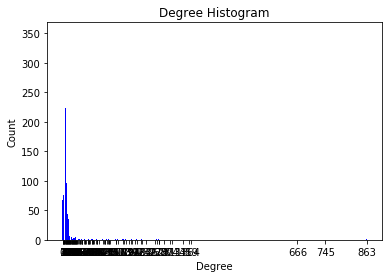

In [168]:
# avg_node_connectivity = nx.networkx.average_node_connectivity(G)
# print('Average node connectivity: ', avg_node_connectivity)

get_histogram(G_sampled)

In [169]:
from networkx.algorithms.community.centrality import girvan_newman
communities_iter = girvan_newman(G_sampled)

communities_sum = 0
communities_gn = []

for community_gn in next(communities_iter):
    communities_sum += 1
    communities_gn.append(community_gn)
    print("Community ", communities_sum)
    print(community_gn)
    print("Liczność community: ", len(community_gn), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
{'JB (#MAGA)', 'Rex Myers 45⭐⭐⭐❌', 'Justice Time', 'Steel', 'Richard', '❌Powerglobal❌', '❌ Pat WestcQtt  ❌', 'Kathleen Donovan', 'Cindyseestruth', 'Ginger Murray', 'Cindi', '👉Ima Nationalist/In The End We win👈', '❌TT🚂 jazz ❌', 'SNARKY by Nature☝🇺🇸  🖕 Cancer', '𝓛𝓲𝓼𝓪 🇺🇸⭐️⭐️⭐️', 'Jennifer 🔱🇺🇸🔱🌟🌟🌟', '🇺🇸GENESIS🇺🇸🌟🌟🌟', '🇺🇸 KO Conservative Republican 🇺🇸', 'GS', 'Robert Infanti', 'SmartDissent.com', 'Trump Force 2020 🇺🇸', 'ProudNavyVeteran 🇺🇸⭐️⭐️⭐️🇺🇸', 'Washington News Line', 'Layla {⭐}', 'leela rose', '🌟TinTX💫#CruzCrew #Trump #KAG🇺🇸', 'beverly j garvey', '🌸🌸Janet Willis🌸🌸', 'Arie #1@Arie Brawley', 'America MUST Unite ⚖️🇺🇸', 'Elbert C. Lyon', 'Cowdog  🇺🇸🗽🇺🇸', '🚂🇺🇸NATIONALIST MAGA SHEILA🇺🇸🚂⭐️⭐️⭐️', 'Charlie D 🕊', '🐘🇺🇸 Kim 🇺🇸🐘', 'joesant', 'MRosenbalm', 'Butch Gass', 'Mike Bacon', 'Chris Fl  1201', '🌹Edge L. Seawolf  #USA Nationalist✈️', 'CeCe  🇺🇸🕆(K) 🐉                     OHIO=RED', 'Karli Bonne’', 'Cyril Wyche', 'Jeff Shadowbanned Cohen', 'Ann Kloentrup 🇺🇸', 'Bridget Rose', 'Want 

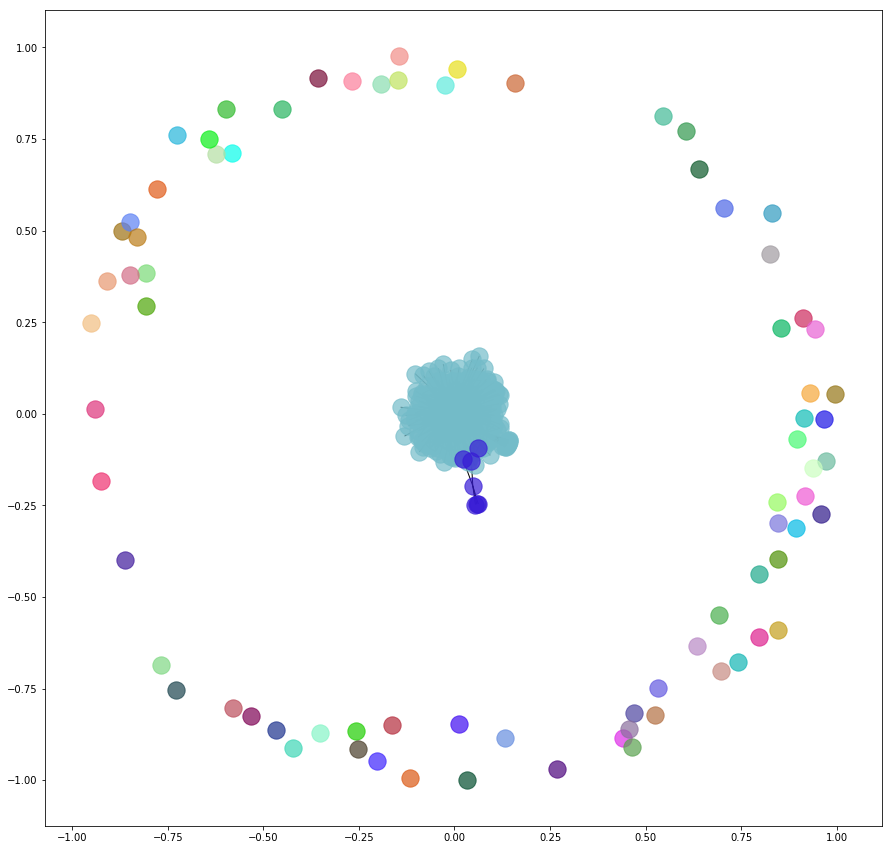

In [170]:
from matplotlib.pyplot import figure
import numpy

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in list(communities_gn):
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [171]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
communities_gmc = greedy_modularity_communities(G_sampled)

communities_sum = 0

for community_gmc in communities_gmc:
    communities_sum += 1
    print("Community ", communities_sum)
    print(community_gmc)
    print("Liczność community: ", len(community_gmc), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
frozenset({'JamieR {🎗} Army Girl', 'Patriot Gary', '🇺🇸Meggs🌴🇺🇸🇺🇸🇺🇸🇺🇸', 'NATIONALIST CKB', '3 People Like This', 'Mac', 'Deplorable Me, B🌟🌟🌟', 'Richard', 'Sandi Pirie⭐️⭐️⭐️', 'Doc Rock ❌', 'Kathleen Donovan', 'Cathy ski', 'Cindi', 'colliertimothy8@gmail.com', '🇺🇸Kimberlee🇺🇸⭐️⭐️⭐️', 'Jeremy (on Politics)', 'Theresa', 'Scott', 'Christine', '🇺🇸GENESIS🇺🇸🌟🌟🌟', 'Mike', 'ACT for America', 'LOOMER', 'james cabbage', 'Trendy Elephant', 'Robert Infanti', 'BibleBeltMomma⭐️⭐️⭐️', 'Washington News Line', 'Rick', 'Toddmarshock #MAGA🇺🇸🇺🇸🇺🇸', 'MD DD', '🇺🇸', '🌸🌸Janet Willis🌸🌸', 'Brandon B', 'America MUST Unite ⚖️🇺🇸', 'bill a bong⭐⭐⭐', 'Leon', 'K Witt\U0001f929🏖️', 'Debbie', 'Gracie Nunyabiz', 'Tamara 😎', 'Dan Olney 🇺🇸 ❌❌❌❌', 'Missgraciemae 🌹', 'Deplorable Reagan❌Nationalist !', 'Nationalist Nora', 'Deplorable me! Force Multiplier', 'joesant', '♞JoxuaLuxor♞', 'Mike Bacon', 'Nate Nelson', 'MAGA nolraM', '❌Raven❌..#MAGA #KAG', 'Jonfbjr⭐⭐⭐', 'Want My Country Back', 'Laurie', 'BrendaAzDeplorable

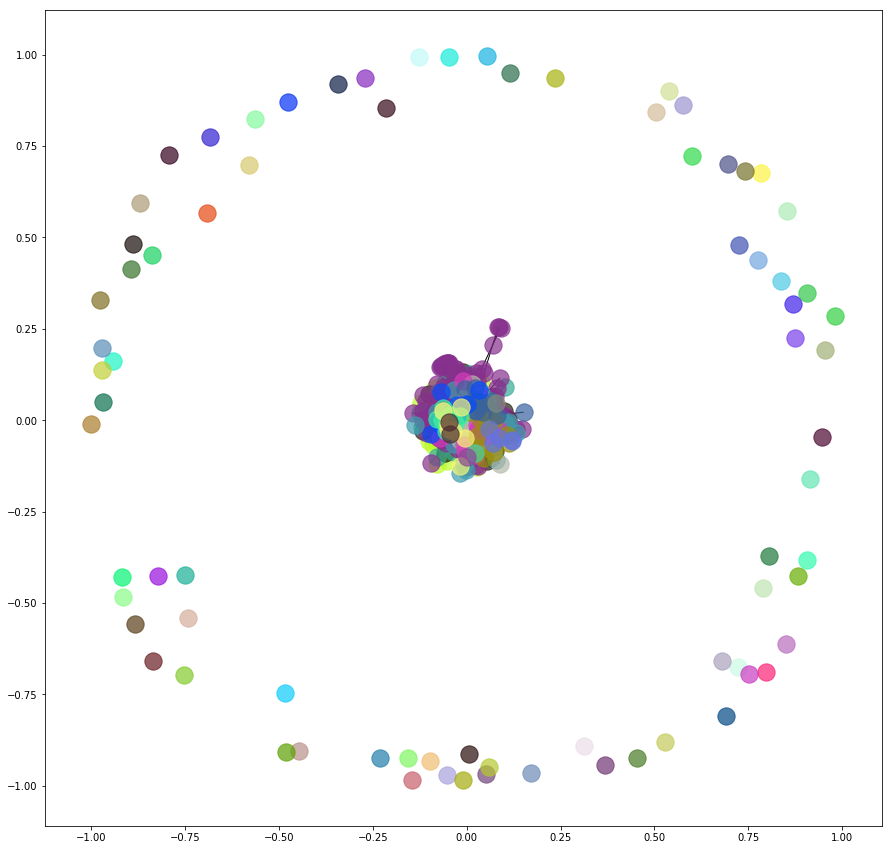

In [172]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in communities_gmc:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [173]:
sorted(G_sampled.degree, key=lambda x: x[1], reverse=True)[:10]


[('Patriot Gary', 863),
 ('TheKat ❤️', 745),
 ('Cody', 666),
 ('Jennifer 🔱🇺🇸🔱🌟🌟🌟', 364),
 ('fordnFLA777 (K)♥️✝️ ❤️✡️', 359),
 ('Chris  🇺🇸 Let Freedom Ring', 341),
 ('🦅 🦅 Nationalist Eagle 🦅🦅', 311),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 304),
 ('🇺🇸 SKY45 🇺🇸 ︻デ═一', 287),
 ('🐘🇺🇸 Kim 🇺🇸🐘', 273)]

In [174]:
degree_centrality = sorted(nx.degree_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [175]:
degree_centrality[:10]

[('Patriot Gary', 0.43432310015098136),
 ('TheKat ❤️', 0.3749370910920986),
 ('Cody', 0.3351786612984399),
 ('Jennifer 🔱🇺🇸🔱🌟🌟🌟', 0.1831907398087569),
 ('fordnFLA777 (K)♥️✝️ ❤️✡️', 0.18067438349270257),
 ('Chris  🇺🇸 Let Freedom Ring', 0.1716155007549069),
 ('🦅 🦅 Nationalist Eagle 🦅🦅', 0.15651736285858078),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 0.15299446401610467),
 ('🇺🇸 SKY45 🇺🇸 ︻デ═一', 0.14443885254151986),
 ('🐘🇺🇸 Kim 🇺🇸🐘', 0.1373930548565677)]

In [176]:
betweenness_centrality = sorted(nx.betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [177]:
betweenness_centrality[:10]

[('Patriot Gary', 0.19181441394888327),
 ('TheKat ❤️', 0.13659055470928877),
 ('Cody', 0.11275642551425281),
 ('fordnFLA777 (K)♥️✝️ ❤️✡️', 0.03590117458537037),
 ('Chris  🇺🇸 Let Freedom Ring', 0.03206624946604979),
 ('Jennifer 🔱🇺🇸🔱🌟🌟🌟', 0.03196283507955331),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 0.0279184298565226),
 ('🦅 🦅 Nationalist Eagle 🦅🦅', 0.023745281142439997),
 ('Laura Vote Red', 0.021254276462776965),
 ('🇺🇸 SKY45 🇺🇸 ︻デ═一', 0.02079763981219131)]

In [178]:
edge_betweenness_centrality = sorted(nx.edge_betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [179]:
edge_betweenness_centrality[:10]

[(('Matthew', 'PoliBot'), 0.007236467581354899),
 (('Jon McNaughton', 'Mike'), 0.0038135405641255217),
 (('Loomered❤️Molly⭐️⭐️⭐️', 'PoliBot'), 0.003681704272266915),
 (('Patriot Gary', 'Cody'), 0.003307055057079051),
 (('Save USA vote red ⭐️⭐️⭐️  🚂💨🇺🇸', 'Cody'), 0.003184413892094193),
 (('Votez Poisson ✝️', 'Jon McNaughton'), 0.0028527747506317583),
 (('Matthew', 'TheKat ❤️'), 0.0026148341881083764),
 (('Chris  🇺🇸 Let Freedom Ring', 'Patriot Gary'), 0.0025317852051441577),
 (('Matthew', 'Patriot Gary'), 0.002335774514507763),
 (('Str8 Don Lemon🍋👫🍺🌈❤', 'Cody'), 0.002230115309342299)]

In [218]:
from networkx.algorithms.community import k_clique_communities
cliques = list(k_clique_communities(G_sampled, 6))

In [225]:
for clique in cliques:
    print(len(clique))
    #print(clique)
print('all cliques: ' + str(len(clique)))

148
9
12
6
11
14
11
all cliques: 11


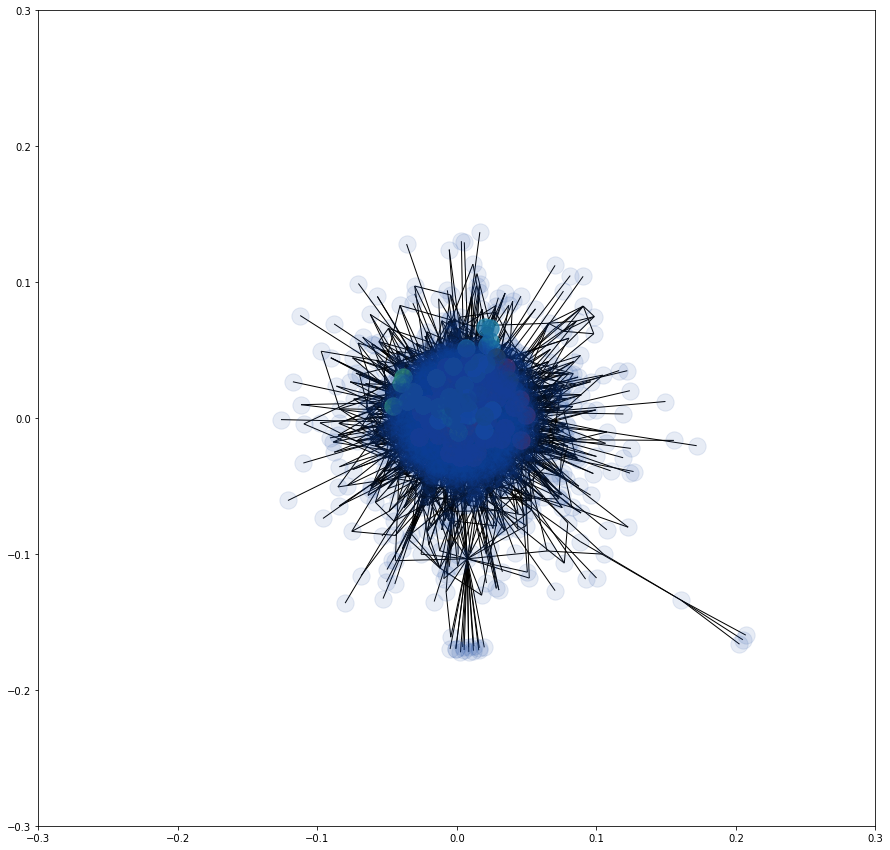

In [226]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for clique in cliques:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=clique,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=G_sampled.nodes,
                           node_color=numpy.random.rand(3,),
                           alpha=0.1)
nx.draw_networkx_edges(G_sampled, pos=pos, nodelist=clique)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)

plt.show()

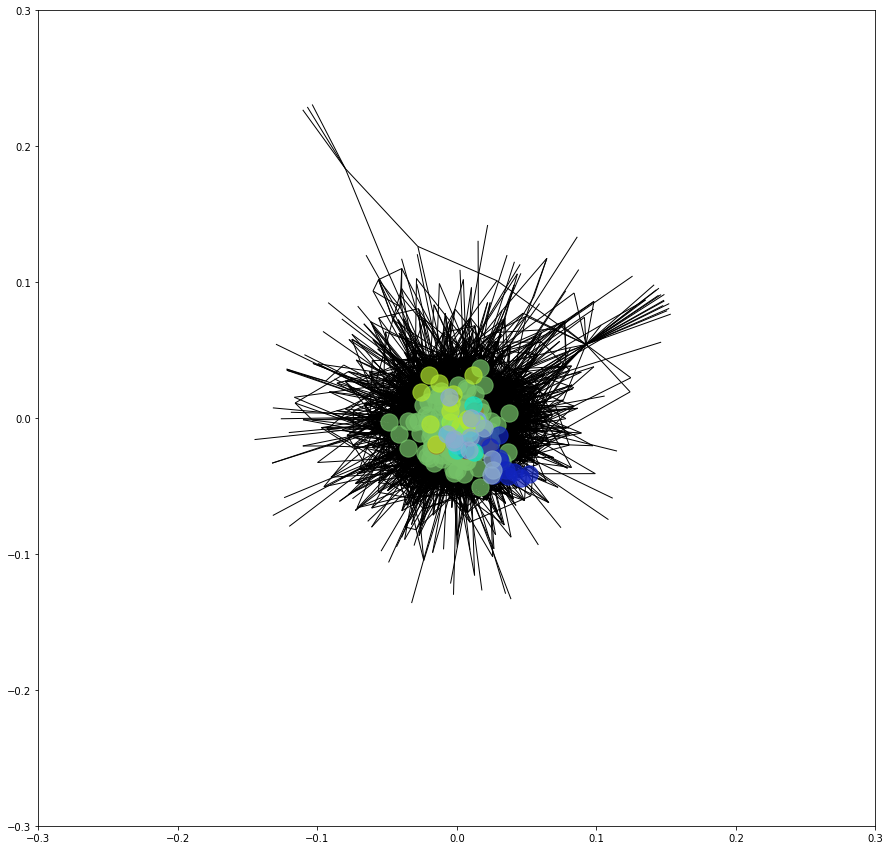

In [232]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for clique in cliques:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=clique,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, nodelist=clique)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)

plt.show()

In [227]:
# active users in distinct cliques

distinct_users_in_cliques = {}

for clique in cliques:
    for user in clique:
        if user in distinct_users_in_cliques:
            distinct_users_in_cliques[user] += 1
        else:
            distinct_users_in_cliques[user] = 1

In [242]:
top_users_in_cliques = sorted(distinct_users_in_cliques.items(), key=lambda x : x[1], reverse=True)
top_users_in_cliques = [(k,v) for k,v in top_users_in_cliques if v>1]
print('users in 2+ cliques: ' + str(len(top_users_in_cliques)))
top_users_in_cliques

users in 2+ cliques: 16


[('👠IStandWithTrump⭐️⭐️⭐️', 3),
 ('@gary[WontBackDown]', 3),
 ('🇺🇸  Consmover 🇺🇸', 3),
 ('Patriot Gary', 2),
 ('Sektor (K)', 2),
 ('Jo4Trump {⭐️} (K) ⭐️⭐️⭐️', 2),
 ('Linda', 2),
 ('Jenny I Voted Red2018', 2),
 ('Jennifer 🔱🇺🇸🔱🌟🌟🌟', 2),
 ('RW 😡', 2),
 ('⚖️JennyVotesRed⚖️', 2),
 ('Nationalist Drew 🇺🇸🏁🍻', 2),
 ('🐘🇺🇸 Kim 🇺🇸🐘', 2),
 ('Nationalist🇺🇸T🇺🇸', 2),
 ('NJaikens 🇺🇸', 2),
 ('Laura Vote Red', 2)]

In [229]:
### Get Vader for this users
user = top_users_in_cliques[10]
users = pd.read_sql_query('SELECT user.user_id AS id, user.user_name, tweet.tweet_id, vader.compound as vader_mood \
                            FROM user \
                             JOIN tweet ON tweet.user_id = user.user_id \
                             JOIN vader ON tweet.tweet_id = vader.id \
                             WHERE user.user_name = "' + user[0] + '"', engine)
users

,id,user_name,tweet_id,vader_mood
